In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data

In [33]:
df_vaers_data = pd.read_csv('./2023VAERSData/2023VAERSDATA.csv', encoding='latin-1')
df_vaers_data.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,2547730,01/01/2023,DE,53.0,NaN,NaN,F,NaN,The adverse event is that the patient went int...,NaN,...,diabetic,NaN,NaN,NaN,2,12/31/2022,NaN,NaN,NaN,none
1,2547731,01/01/2023,MA,6.0,6.0,NaN,M,NaN,Error: Incorrect Reconstitution-,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN
2,2547732,01/01/2023,MA,38.0,38.0,NaN,F,NaN,Error: Patient Accidentally Stuck by Needle-,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN
3,2547733,01/01/2023,CA,63.0,63.0,NaN,M,NaN,Error: Dose in Series Given Too Early-,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN
4,2547734,01/01/2023,IL,30.0,30.0,NaN,F,NaN,Systemic: EYE TWITCHING-Medium,NaN,...,NaN,NaN,NaN,NaN,2,01/01/2023,NaN,NaN,NaN,NaN


In [39]:
df_sympt = pd.read_csv('./2023VAERSData/2023VAERSSYMPTOMS.csv', encoding='latin-1')
df_sympt.head()

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,2547730,Blood pressure orthostatic abnormal,25.1,COVID-19,25.1,Coma,25.1,Computerised tomogram,25.1,Exposure to SARS-CoV-2,25.1
1,2547730,Head injury,25.1,Headache,25.1,Laboratory test,25.1,Magnetic resonance imaging,25.1,SARS-CoV-2 antibody test negative,25.1
2,2547730,SARS-CoV-2 test positive,25.1,Unresponsive to stimuli,25.1,X-ray,25.1,NaN,NaN,NaN,NaN
3,2547731,Product preparation issue,25.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2547732,Injury associated with device,25.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_vax = pd.read_csv('./2023VAERSData/2023VAERSVAX.csv', encoding='latin-1')
df_vax.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,2547730,COVID19,JANSSEN,1808982,UNK,SYR,AR,COVID19 (COVID19 (JANSSEN))
1,2547731,COVID19,PFIZER\BIONTECH,GK1657,3,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
2,2547732,COVID19-2,MODERNA,141H22A,4,IM,LA,COVID19 (COVID19 (MODERNA BIVALENT))
3,2547733,COVID19,MODERNA,042h22a,1,IM,LA,COVID19 (COVID19 (MODERNA))
4,2547734,TDAP,GLAXOSMITHKLINE BIOLOGICALS,KP547,1,IM,LA,TDAP (BOOSTRIX)


## Process Data
#### a. Select a vaccine type based on VAERS Vaccine table. For example, COVID19, FLU3, or TDAP.
#### b. Based on the VAERS_ID, get around 10,000 reports related to the vaccine you selected from the column SYMPTOM_TEXT in the VAERS DATA table.

In [36]:
df_covid19 = df_vax[df_vax['VAX_TYPE'] == 'COVID19']
vaers_ids_covid19 = df_covid19['VAERS_ID'].unique()
vaers_ids_covid19[:10], len(vaers_ids_covid19)

(array([2547730, 2547731, 2547733, 2547739, 2547741, 2547744, 2547745,
        2547746, 2547747, 2547749], dtype=int64),
 40186)

In [37]:
df_covid19_reports = df_vaers_data[df_vaers_data['VAERS_ID'].isin(vaers_ids_covid19)]
df_covid19_symptoms = df_covid19_reports[['VAERS_ID', 'SYMPTOM_TEXT']].head(10000)
df_covid19_symptoms.head(), len(df_covid19_symptoms)

(    VAERS_ID                                       SYMPTOM_TEXT
 0    2547730  The adverse event is that the patient went int...
 1    2547731                   Error: Incorrect Reconstitution-
 3    2547733             Error: Dose in Series Given Too Early-
 8    2547739             Error: Dose in Series Given Too Early-
 10   2547741  Considerable swelling of left hand which preve...,
 10000)

#### c. Perform some statistical analysis of your data. For example, you can get the distribution of the number of different symptoms related that vaccine type. You can also get the distribution of the length of different reports.

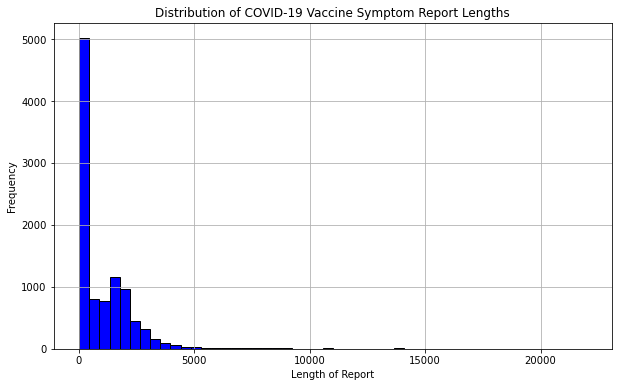

count    10000.000000
mean      1042.349700
std       1430.146538
min          2.000000
25%        113.000000
50%        439.000000
75%       1677.000000
max      21985.000000
Name: REPORT_LENGTH, dtype: float64

In [38]:
df_covid19_symptoms['SYMPTOM_TEXT'] = df_covid19_symptoms['SYMPTOM_TEXT'].astype(str)
df_covid19_symptoms['REPORT_LENGTH'] = df_covid19_symptoms['SYMPTOM_TEXT'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df_covid19_symptoms['REPORT_LENGTH'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of COVID-19 Vaccine Symptom Report Lengths')
plt.xlabel('Length of Report')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

report_length_stats = df_covid19_symptoms['REPORT_LENGTH'].describe()
report_length_stats

#### d. For the reports you selected in 2.b, build the corresponding standard symptom list with the symptoms in VAERS Symptoms table. Further, please find the most common symptoms (e.g., the most frequent 100 symptoms.)

In [42]:
df_covid19_symptoms_full = pd.merge(df_covid19_symptoms[['VAERS_ID']], df_sympt, on='VAERS_ID', how='inner')
symptom_columns = [col for col in df_sympt.columns if 'SYMPTOM' in col]
df_covid19_symptoms_full['SYMPTOMS_LIST'] = df_covid19_symptoms_full[symptom_columns].values.tolist()
all_symptoms = [symptom for sublist in df_covid19_symptoms_full['SYMPTOMS_LIST'].tolist() for symptom in sublist if pd.notnull(symptom)]
symptom_counts = pd.Series(all_symptoms).value_counts()

top_100_symptoms = symptom_counts.head(100)
top_100_symptoms

25.1                        43470
COVID-19                     2847
No adverse event             1995
SARS-CoV-2 test positive     1589
Product storage error        1211
                            ...  
Syncope                        70
Anxiety                        70
Back pain                      69
Abdominal pain                 69
Laboratory test abnormal       68
Length: 100, dtype: int64

This most common symptom '25.1' doesn't seems like an actual symtom. Let's remove it so that `COVID-19` and `No adverse event` as two most common symptom looks more realistic.

In [43]:
symptom_counts.index = symptom_counts.index.map(str)
symptom_counts_cleaned = symptom_counts.drop(labels=["25.1"])
top_100_symptoms_cleaned = symptom_counts_cleaned.head(100)
top_100_symptoms_cleaned

COVID-19                        2847
No adverse event                1995
SARS-CoV-2 test positive        1589
Product storage error           1211
Expired product administered    1097
                                ... 
Anxiety                           70
Back pain                         69
Abdominal pain                    69
Laboratory test abnormal          68
Muscular weakness                 68
Length: 100, dtype: int64

## STEP 1: Extracting Symptom-related Entities:
### Task:
- Input: Description of vaccine adverse events (i.e., SYMPTOM TEXT in VAERS DATA table).
- Output: A list of symptom related entities.
- Evaluation: There is no ground truth annotation for the data. You need to manually check 20+ reports to see if there are entities that are missed by the model or package.